In [1]:
from skimage import io
from typing import Iterable, Tuple, Dict, Union
from numba import njit
from numba.typed import List as Nlist

from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_fill_holes
from skimage.filters import threshold_li, gaussian
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import binary_opening
from skimage.draw import rectangle_perimeter, ellipse_perimeter
from skimage.color import gray2rgb
from matplotlib.patches import Ellipse

import matplotlib.pyplot as plt
import numpy as np
import os, math, csv

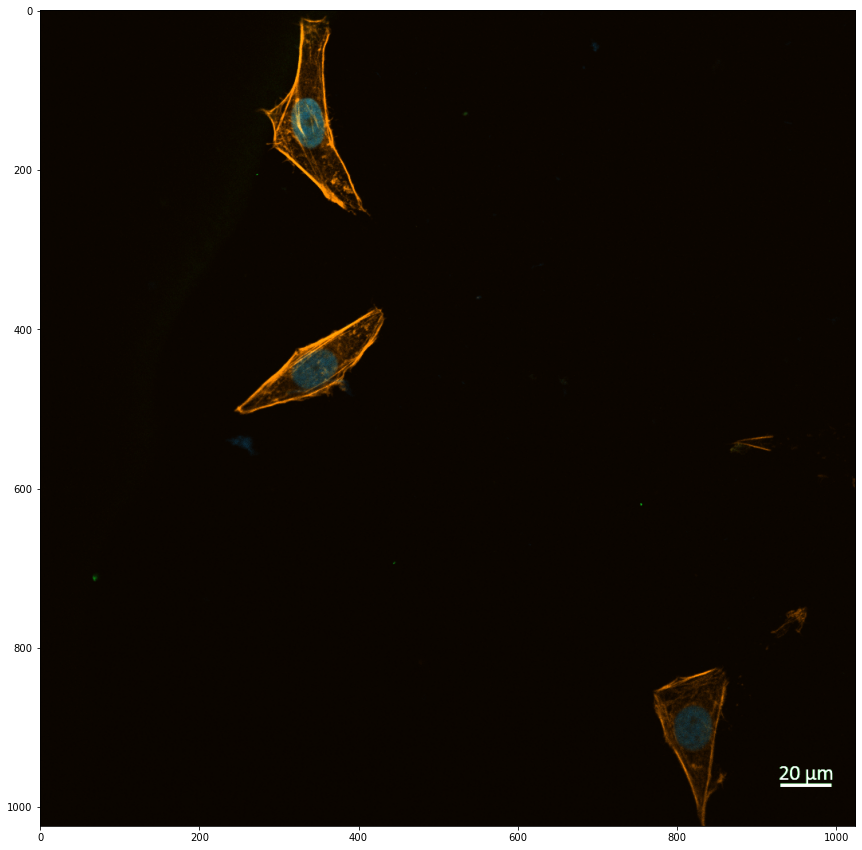

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Import images
images = []
for f in os.listdir("Images"):
    if ".tif" in f:
        images.append(f"Images/{f}")
plt.figure(figsize=(15, 15))
plt.imshow(io.imread(images[4]))
plt.show()

In [3]:
@njit(cache=True)
def get_area_bounding_box(area: Iterable[Tuple[int, int]]) -> Tuple[int, int, int, int]:
    """
    Method to get the bounding box of the given area
    
    :param area: The area to calculate the bounding box of
    :return: The bounding box in form of y, x, height, width
    """
    xvals = [x[1] for x in area]
    yvals = [x[0] for x in area]
    return amin(yvals), amin(xvals), amax(yvals) - amin(yvals), amax(xvals) - amin(xvals)
    

@njit(cache=True)
def amin(array: Iterable) -> Union[int, float]:
    """
    Numba wrapper for np.amin
    """
    amin = 0x7FFFFFFF
    for x in array:
        amin = amin if x > amin else x
    return amin


@njit(cache=True)
def amax(array: Iterable) -> Union[int, float]:
    """
    Numba wrapper for np.amax
    """
    amax = 0
    for x in array:
        amax = amax if x < amax else x
    return amax

    
@njit(cache=True)
def get_area_map(img: np.ndarray, threshold: int = 15) -> np.ndarray:
    """
    Function to merge the red and green channel to obtain a binary area map
    
    :param img: The image
    :return: The binary area map
    """
    # Create array for map
    binmap = np.zeros(shape=(img.shape[0], img.shape[1]))
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y][x][0] > threshold or img[y][x][1] > threshold:
                binmap[y][x] = 1
    return binmap
  

@njit(cache=True)
def get_center(area: Iterable[Tuple[int, int]]) -> Tuple[int, int]:
    """
    Method to get the center of the given area
    
    :param area: The area to calculate the center of
    :return: The center als tuple
    """
    xc = 0
    yc = 0
    num = len(area)
    for p in area:
        xc += p[1]
        yc += p[0]
    return yc / num, xc / num

        
@njit(cache=True)
def get_orientation(area: Iterable[Tuple[int, int]]) -> Tuple[float, float]:
    """
    Function to get the orientation vector of this area
    
    :param area: The area to get the orientation from
    :return: The orientation vector as tuple
    """
    m11 = get_central_moment(area, 1, 1)
    m20 = get_central_moment(area, 2, 0)
    m02 = get_central_moment(area, 0, 2)
    a = 2 * m11
    b = m20 - m02
    if a == b:
        return (0.0 , 0.0), 0
    else:
        fak = b / math.sqrt(a * a + b * b)
        x = math.sqrt(0.5 * (1 + fak))
        y = math.sqrt(0.5 * (1 - fak))
        if a < 0:
            y *= -1
        return (y, x) , 0.5 * math.atan2(m20 - m02, 2 * m11)

    
@njit(cache=True)
def get_eccentricity(area: Iterable[Tuple[int, int]]) -> float:
    """
    Function to calculate the eccentricity of the area
    
    :param area: The area to calculate the eccentricity of
    :return: The eccentricity as float
    """
    # Get needed central moments
    m20 = get_central_moment(area, 2, 0)
    m02 = get_central_moment(area, 0, 2)
    m11 = get_central_moment(area, 1, 1)
    a1 = m20 + m02 + math.sqrt(((m20 - m02)**2) + 4 * (m11**2))
    a2 = m20 + m02 - math.sqrt(((m20 - m02)**2) + 4 * (m11**2))
    return a1 / a2


@njit(cache=True)
def get_ellipse_radii(area: Iterable[Tuple[int, int]]) -> Tuple[float, float]:
    """
    Method to get the radii of the enclosing ellipse for this area
    
    :param area: The area
    :return: The major and minor radius
    """
    m20 = get_central_moment(area, 2, 0)
    m02 = get_central_moment(area, 0, 2)
    m11 = get_central_moment(area, 1, 1)
    a1 = m20 + m02 + math.sqrt(((m20 - m02)**2) + 4 * (m11**2))
    a2 = m20 + m02 - math.sqrt(((m20 - m02)**2) + 4 * (m11**2))
    ar = len(area)
    return math.sqrt(((2 * a1)/ ar)), math.sqrt(((2 * a2)/ ar))


@njit(cache=True)
def get_perimeter(area: Iterable[Tuple[int, int]]) -> int:
    """
    Function to get the perimeter of the given area
    
    :param area: The area to get the perimeter from
    :return: The perimeter of the area
    """
    # Get bounding box 
    bb = get_area_bounding_box(area)
    pmap = np.zeros((bb[2] + 1, bb[3] + 1))
    cy, cx = bb[0], bb[1]
    # Create map containing all points
    for p in area:
        ty, tx = p[0] - cy, p[1] - cx
        pmap[ty][tx] = 1
    perimeter = 0
    # Check for transitions between background and foreground
    for y in range(bb[2]):
        for x in range(bb[3]):
            # If point is on map corner, it is part of the perimeter
            if (y == 0 or y == bb[2] - 1 or x == 0  or x == bb [3] - 1) and pmap[y][x]:
                perimeter += 1
            elif pmap[y][x]:
                if not pmap[y - 1][x] or not pmap[y + 1][x] \
                or not pmap[y][x - 1] or not pmap[y][x + 1]:
                    perimeter += 1
    return perimeter
                       
                    
@njit(cache=True)
def get_ovality(area: Iterable[Tuple[int, int]]) -> float:
    """
    Function to calculate the ovality of the given area
    
    :param area: The area to calculate the ovality from
    :return: The ovality as float
    """
    # Get perimeter
    per = get_perimeter(area)
    are = len(area)
    return 4 * math.pi * are / per ** 2


@njit(cache=True)
def get_central_moment(area: Iterable[Tuple[int, int]], p: int, q: int) -> float:
    """
    Function to calculate the central moment of the given area
    
    :param area: The area to calculate the moment from
    :param p: The exponent of the x coordinate
    :param q: The exponent of the y coordinate
    :return: The central moment of this area
    """
    mom = 0.0
    # Calculate area -> equivalent to get_moment(area, 0, 0)
    m00 = len(area)
    # Get center of mass -> equivalent to get_moment(area, 1, 0) and get_moment(area, 0, 1)
    m01, m10 = get_center(area)
    for point in area:
        mom += ((point[1] - m10) ** p) * ((point[0] - m01) ** q)
    return mom


@njit(cache=True)
def get_moment(area: Iterable[Tuple[int, int]], p: int, q: int) -> float:
    """
    Function to calculate the moment of the given area
    
    :param area: The area to calculate the moment from
    :param p: The exponent of the x coordinate
    :param q: The exponent of the y coordinate
    :return: The central moment of this area
    """
    mom = 0.0
    for point in area:
        mom += (point[1] ** p) * (point[0] ** q)
    return mom


def extract_areas(area_map: np.ndarray) -> Dict[int, Iterable[Tuple]]:
    """
    Function to extract individual areas from the given map
    
    :param area_map: The map to extract the areas from
    :return: The extracted areas as dictionary
    """
    areas = {}
    height, width = area_map.shape
    for y in range(height):
        for x in range(width):
            if area_map[y][x] > 0:
                if areas.get(area_map[y][x], False):
                    areas[area_map[y][x]].append((y, x))
                else:
                    area = Nlist()
                    area.append((y, x))
                    areas[area_map[y][x]] = area
    return {x:y for x, y in areas.items() if len(y) > 10}

    
@njit(cache=True)
def threshold_channel(img: np.ndarray, threshold: float) -> np.ndarray:
    """
    Function to binarize the given channel
    
    :param img: The image to binarize
    :param threshold: The threshold to use
    :return: The thresholded image
    """
    return img > threshold


@njit(cache=True)
def selective_flood_fill(areas: np.ndarray, markers: Iterable[Tuple[int, int]]) -> np.ndarray:
    """
    Function to perform a selective flood fill
    
    :param areas: The area map to separate
    :param markers: The markers to use as seed points for flood fill
    :return: The separated areas
    """
    height, width = areas.shape
    ff = np.zeros(shape=areas.shape)
    # Draw markers into map
    lbl = 2
    for marker in markers:
        ff[marker[0]][marker[1]] = lbl
        lbl += 1
    points = Nlist(markers)
    # Perform flood-fill
    while points:
        tpoints = []
        for y2 in range(-1, 2, 1):
            for x2 in range(-1, 2, 1):
                for p in points:
                    y, x = p
                    if ff[y][x]:         
                        ny = max(0, y + y2) if y + y2 <= height - 1 else height -1
                        nx = max(0, x + x2) if x + x2 <= width - 1 else width -1
                        if ff[ny][nx] == 0 and areas[ny][nx] > 0:
                            ff[ny][nx] = ff[y][x]
                            tpoints.append((ny, nx))
        points.clear()
        points.extend(tpoints)
    return ff

In [4]:
def extract_nuclei(img: np.ndarray) -> np.ndarray:
    """
    Function to extract the nuclei from the given image
    
    :param img: The image to extract the channel from
    :return: The extracted nuclei
    """
    # Copy image
    img = img.copy()
    # Get blue channel
    blue = img[..., 2]
    # Calculate LI threshold
    thresh = threshold_li(img)
    # Apply threshold to channel
    blue_bin = threshold_channel(blue, thresh)
    # Fill holes
    blue_bin = binary_fill_holes(blue_bin)
    # Apply binary opening to reduce noise
    blue_bin = binary_opening(blue_bin, selem=np.full((10, 10), True))
    # Extract individual areas from bin. image via watershed segmentation
    dist = ndi.distance_transform_edt(blue_bin)
    # Blur distance map to smooth out maxima detection
    dist = gaussian(dist, sigma=3)
    loc_max = peak_local_max(dist, indices=False, footprint=np.ones((50, 50)),
                             labels=blue_bin)
    markers = ndi.label(loc_max)[0]
    return watershed(-dist, markers, mask=blue_bin)


def show_nucleus_orientation(img: np.ndarray) -> None:
    """
    Function to show the calculated centers and orientations of each detected nucleus
    
    :param img: The image to extract the nuclei from
    :return: None
    """
    nucleus_map = extract_nuclei(img)
    # Extract individual areas from map 
    nuclei = extract_areas(nucleus_map)
    # Calculate orientation and  center of each nucleus
    orient = {}
    for label, area in nuclei.items():
        orient[label] = (get_center(area), get_orientation(area))
    # Get labelled area map
    area_map = ndi.label(get_area_map(img))[0]
    plt.figure(figsize=(10, 10))
    # Draw detected orientation and center
    for nucleus, data in orient.items():
        cy, cx = data[0]
        oy, ox = data[1][0]
        bb = get_area_bounding_box(nuclei[nucleus])
        plt.plot((cx, ox * 25 + cx), (cy, oy * 25 + cy))
        rr, cc = rectangle_perimeter((bb[0], bb[1]), extent=(bb[2], bb[3]))
        nucleus_map[rr, cc] = len(nuclei) + 1
    plt.imshow(nucleus_map)
    plt.show()
    

def save_data_to_csv(data: Iterable[Iterable], name: str="results.csv") -> None:
    """
    Function to save the analysis data to .csv
    
    :param data: The data to save
    :param name: The file name for the output csv
    :return: None
    """
    with open(name, "w", newline="\n") as csvfile:
        writer = csv.writer(csvfile, delimiter=";",
                            quotechar="|", quoting=csv.QUOTE_MINIMAL)
        for row in data:
            row = [str(x) for x in row]
            writer.writerow(row)


def extract_data(img: np.ndarray, img_path: str) -> Iterable[Iterable[Union[int, float, str]]]:
    """
    Function to separate the areas on the given image
    
    :param img: The image
    :return: The extracted data
    """
    csv_nuclei = []
    csv_cells = []
    height, width, _ = img.shape
    # Get the area map
    nucleus_map = extract_nuclei(img)
    # Extract individual areas from map 
    nuclei = extract_areas(nucleus_map)
    # Collect data for each nucleus
    #orient = {}
    for label, area in nuclei.items():
        cy, cx = get_center(area)
        ov, an = get_orientation(area)
        oy, ox = ov[0], ov[1]
        ell_1, ell_2 = get_ellipse_radii(area)
        row = (img_path, cx, cy, oy, oy, an,
               get_eccentricity(area), get_ovality(area),
               ell_2, ell_1, min(ell_1, ell_2) / max(ell_1, ell_2))
        #orient[label] = row
        csv_nuclei.append(row)
    # Get labelled area map
    area_map = get_area_map(img)
    area_map = binary_fill_holes(area_map)
    area_map = binary_opening(area_map, selem=np.full((15, 15), True))
    area_copy = np.copy(area_map.astype("uint8"))
    area_map = ndi.label(area_map)[0]
    # Connect nuclei to regions
    conn_areas = {}
    for y in range(height):
        for x in range(width):
            if area_map[y][x] != 0 and nucleus_map[y][x] != 0:
                if conn_areas.get(area_map[y][x], False):
                    conn_areas[area_map[y][x]].add(nucleus_map[y][x])
                else:
                    conn_areas[area_map[y][x]] = {nucleus_map[y][x]}
    conn_areas = {x: list(y) for x, y in conn_areas.items()}
    markers = Nlist()
    for nucleus, points in nuclei.items():
        y, x = get_center(points)
        y = round(y)
        x = round(x)
        markers.append((y, x))
    area_map = selective_flood_fill(area_map, markers)
    # Get areas as tuple list
    areas = extract_areas(area_map)
    amax = np.amax(area_map)
    area_map = area_map * (255/amax)
    # Calculate orientation of detected areas
    orient = {}
    for label, area in areas.items():
        orient[label] = (get_center(area), get_orientation(area),
                         get_eccentricity(area), get_ovality(area),
                         get_ellipse_radii(area))
    # Draw detected orientation and center
    for cell, data in orient.items():
        cy, cx = data[0]
        oy, ox = data[1][0]
        angle = (-math.degrees(data[1][1]) + 90) % 360 - 45
        ecc = data[2]
        oval = data[3]
        min_r, maj_r = data[4]
        bb = get_area_bounding_box(areas[cell])
        # Save data
        csv_cells.append(
            # cen. x, cen. y, or x, or y, or. angl, ecc, oval, ell_maj, ell_min, bb
            (img_path, cx, cy, ox, oy, angle, ecc,
             oval, maj_r, min_r, min(maj_r, min_r) / max(maj_r, min_r))
        )
    return csv_cells, csv_nuclei

In [5]:
cell_data = []
nuclei_data = []
for img in images:
    cells, nuclei = extract_data(io.imread(img), img)
    cell_data.extend(cells)
    nuclei_data.extend(nuclei)
save_data_to_csv(cell_data)
save_data_to_csv(nuclei_data, "results_nuclei.csv")

## Cell classification

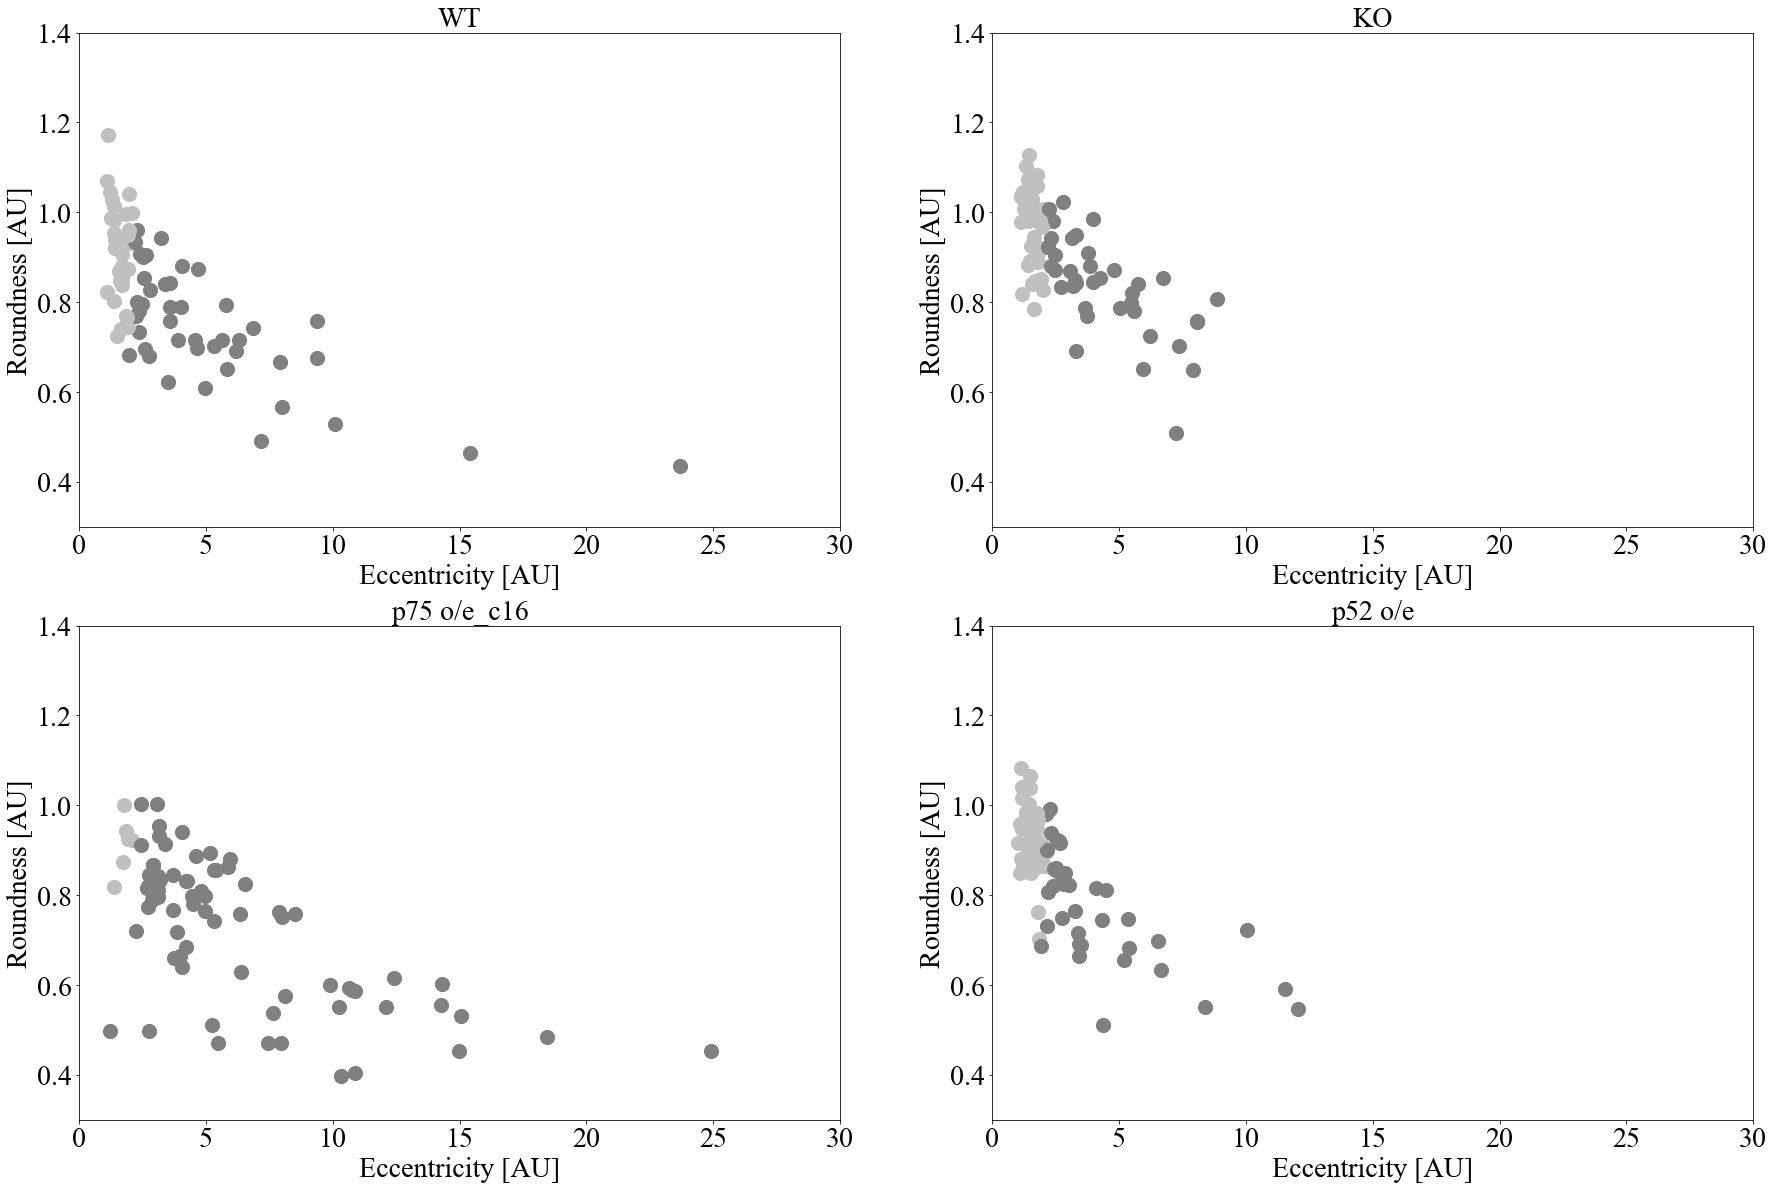

In [10]:
# Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.cluster import DBSCAN
from skimage import io
from mpl_toolkits.mplot3d import Axes3D

def check_cell_type(name: str) -> int:
    """
    Method to check the cell type according to the file name of the image
    
    :param name: The file name of the image
    """
    if "WT" in name:
        return 0
    if "E1_4cr." in name:
        if "c16" in name:
            return 2
        if "p52" in name:
            return 3
        return 1
 

state = 42
# Define markers for each cell type WT, KO, p75, p52
markers = ["o", "o", "o", "o"]
names = ["WT", "KO", "p75 o/e_c16", "p52 o/e"]
# Create datafram from csv
df = pd.read_csv("results.csv", sep=";", header=None,
                 usecols=[0, 1, 2, 6, 7, 10])
df_nuc = pd.read_csv("results_nuclei.csv", sep=";", header=None,
                     usecols=[0, 1, 2, 6, 7, 10])
df.columns = ["Image", "Center X", "Center Y", "Eccentricity", "Roundness", "Ratio"]
df_nuc.columns = ["Image", "Center X", "Center Y", "Eccentricity", "Roundness", "Ratio"]
# Add nucleus eccentricity to dataframe
df["N. Eccentricity"] = df_nuc["Eccentricity"]
# Perform k-means clustering
db = DBSCAN(eps=0.15, min_samples=45).fit(df[["Eccentricity",
                                              "Roundness"]])
# Add results to dataframe
df["Morphology"] = db.labels_
# Define parameters for plotting
font = {'family' : 'Times New Roman',
        'size'   : 16}
mpl.rc('font', **font)

fig, axes = plt.subplots(figsize=(30, 20), nrows=2, ncols=2)
plt.title("DBSCAN Clustering")
# Define lists to use for plotting
paths = df["Image"].tolist()
ecc = df["Eccentricity"].tolist()
rou = df["Roundness"].tolist()
ecc_n = df["N. Eccentricity"].tolist()
scatter_c = df["Morphology"].tolist()

samples = [0, 0, 0, 0]
# Create scatter plot
for ind in range(len(paths)):
    # Check cell type
    type_ = check_cell_type(paths[ind])
    i, j = 0, 0
    if type_ == 1:
        i, j = 0, 1
    if type_ == 2:
        i, j = 1, 0
    if type_ == 3:
        i, j = 1, 1
    if samples[type_] < 75:
        axes[i][j].scatter(ecc[ind], rou[ind],
                           color="gray" if scatter_c[ind] == -1 else "silver",
                           marker=markers[type_],
                           s=200,
                           label=names[type_])
    samples[type_] += 1
# Set Axis labels
size=28
for i in range(2):
    for j in range(2):
        axes[i][j].set_title(names[i * 2 + j], size=size)
        axes[i][j].set_ylim(0.3, 1.4)
        axes[i][j].set_xlim(0, 30)
        axes[i][j].set_ylabel("Roundness [AU]", size=size)
        axes[i][j].set_xlabel("Eccentricity [AU]", size=size)
        axes[i][j].tick_params(axis='both', which='major', labelsize=size)
        axes[i][j].tick_params(axis='both', which='minor', labelsize=size)
plt.show()